# On-the-fly Code Generation for Postprocessing

In this notebook, we demonstrate how to add postprocessing functions to an existing model.

In [1]:
import sys
import difflib
import numpy as np

sys.path.append('../../neural')

from synapse import *
from neuron import *
from cuda import CudaGenerator

## Define a postprocessing function
We first generate the CUDA code for the Hodgkin-Huxley model before defining a postprocessing function.

In [2]:
hh = HodgkinHuxley()
code_generator = CudaGenerator(hh)
code_generator.generate()

Define postprocessing function, and add the function to the Hodgkin-Huxley model. The postprocessing function first detects and counts the spike event.

In [3]:
def post(self):
    self.spike = (self.v1 < self.v2) * (self.v < self.v2) * (self.v > -30.)
    self.v1 = self.v2
    self.v2 = self.v
    self.count += self.spike

HodgkinHuxley.post = post
HodgkinHuxley.Default_Inters.update({'v1': -65, 'v2': -65, 'count': 0.})

Now, generate the CUDA code with the postprocessing function.

In [4]:
hh1 = HodgkinHuxley()
code_generator1 = CudaGenerator(hh1)
code_generator1.generate()

Compare the difference of the generated CUDA code with and withou the postprocessing function.

In [5]:
lines = difflib.unified_diff(
    code_generator.cuda_src.split('\n'),
    code_generator1.cuda_src.split('\n'),
    fromfile='Without Postprocessing',
    tofile='With Postprocessing')

for line in lines:
    print line

--- Without Postprocessing

+++ With Postprocessing

@@ -23,6 +23,9 @@

 };
 
 struct Inters {
+    float count;
+    float v1;
+    float v2;
     float spike;
 };
 
@@ -88,6 +91,19 @@

 }
 
 
+/* post processing */
+__device__ int post(
+    States &states,
+    Inters &inters
+)
+{
+
+    inters.spike = (((inters.v1 < inters.v2) * (states.v < inters.v2)) * (states.v > -30.0));
+    inters.v1 = inters.v2;
+    inters.v2 = states.v;
+    inters.count = (inters.count + inters.spike);
+    return 0;
+}
 
 __global__ void HodgkinHuxley (
     int num_thread,
@@ -96,6 +112,9 @@

     float *g_n,
     float *g_m,
     float *g_v,
+    float *g_count,
+    float *g_v1,
+    float *g_v2,
     float *g_spike,
     float *g_stimulus
 )
@@ -114,6 +133,9 @@

     states.n = g_n[tid];
     states.m = g_m[tid];
     states.v = g_v[tid];
+    inters.count = g_count[tid];
+    inters.v1 = g_v1[tid];
+    inters.v2 = g_v2[tid];
     inters.spike = g_spike[tid];
     float stimulus = g_stimulus[tid];


## Execute the postprocessing function

In [6]:
import time

import pycuda
import pycuda.autoinit
import pycuda.driver as cuda
import pycuda.gpuarray as garray

from utils import generate_stimulus

Setup simulation.

In [7]:
dt  = 5e-5
dur = 2.
num = 5000
amp = 20.
dtype = np.float32

waveform = generate_stimulus('step', dt, dur-dt/2, (0.5, 1.5), amp, dtype=dtype)
t = np.arange(0, len(waveform)*dt-dt/2, dt)
scale = np.linspace(0.5, 5., num, dtype=dtype)

Generate CUDA code on-the-fly.

In [8]:
hh1.cuda_prerun(num=num, dtype=dtype)

Allocate GPU data.

In [9]:
V = np.zeros((len(waveform), num), dtype=dtype)
d_stim = garray.empty(num, dtype=dtype)

Execute the CUDA kernel.

In [10]:
start = time.time()
for i, w in enumerate(waveform):
    stimulus = w*scale
    cuda.memcpy_htod(d_stim.gpudata, stimulus)
    hh1.cuda_update(dt, stimulus=d_stim)
    V[i] = hh1.v.get()
print("Execution Time: %f" % (time.time() - start))

Execution Time: 5.871921


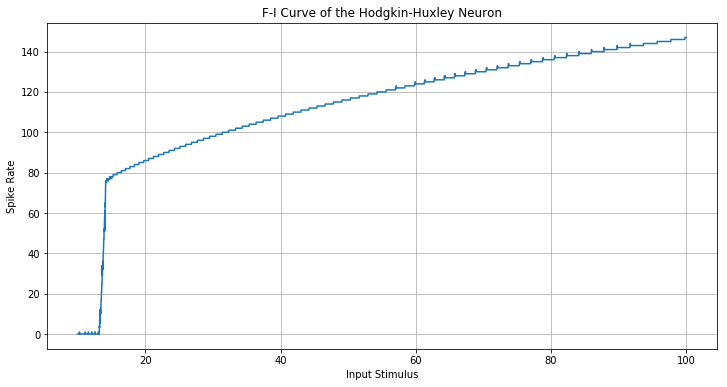

In [12]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(scale*amp, hh1.count.get())
plt.grid('On')
plt.xlabel('Input Stimulus');
plt.ylabel('Spike Rate');
plt.title('F-I Curve of the Hodgkin-Huxley Neuron');